# Post-analyze

For better interpretation of results.

**Make sure to run analyze.py, grade_label.py, compare_with_label.py in advance.**

We consider the converted molecular graph is chemically valid (or *ChemVal* shortly, hereinafter) if

- the total charge of the molecular graph is identical to the value passed as input
- none of atoms have odd number of electrons (no unpaired electron)
- RDKit `Chem.SanitizeMol` does not raise error

We consider the converted molecular graph is the most chemically stable (or *ChemStab* shortly, hereinafter) if

- the number of atoms satisfying the octet rule is the most.
- the formal charge separation is the least.
- the number of atoms participating in conjugate (aromatic) system is the most.

## Modules

In [58]:
import os.path as osp
import pathlib
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import Draw
MOLSIZE=(500,500)
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.includeRadicals = True
IPythonConsole.molSize = MOLSIZE

In [6]:
from convert import main_charge, indigox_charge, xyz2mol_charge, obabel_charge
from grade_noAns import check_noRadical

## Setups

In [ ]:
XYZ = pathlib.Path.cwd() / "DATA" / "PubChemQC" / "neutral"
EXP = pathlib.Path.cwd() / "PubChemQC2025" / "exp250224" # path/to/experiment/directory

## DATA Loading

In [ ]:
_OBB_PKL = "df_obabel.pkl"
_IGX_PKL = "df_indigox.pkl"
_X2M_PKL = "df_xyz2mol.pkl"
_BOS_PKL = "df_bos.pkl"
_ANA_PKL = "df_ana.pkl"

In [ ]:
OBB_PKL = EXP / _OBB_PKL
IGX_PKL = EXP / _IGX_PKL
X2M_PKL = EXP / _X2M_PKL
BOS_PKL = EXP / _BOS_PKL
ANA_PKL = EXP / _ANA_PKL
TIMEFIG = EXP / "time.png"
VS_LAB = EXP / "vs_label.csv"

In [69]:
with open(ANA_PKL, "rb") as f:
    ana = pickle.load(f)
    ana.drop(ana[ana["name"].str.contains("Valence")].index, inplace=True)
ana=ana.loc[:,~ana.columns.duplicated()]

In [ ]:
with open(BOS_PKL, "rb") as f:
    bos = pickle.load(f)

In [71]:
with open(OBB_PKL, "rb") as f:
    obb = pickle.load(f)

In [72]:
with open(IGX_PKL, "rb") as f:
    igx = pickle.load(f)

In [73]:
with open(X2M_PKL, "rb") as f:
    x2m = pickle.load(f)
    x2m.drop(x2m["name"].str.contains("Valence").index, inplace=True)
    

In [74]:
chemstab_pkl = osp.join(EXP, "chemstab_res.pkl")
with open(chemstab_pkl, "rb") as f:
    chemstab_res = pickle.load(f)

Time Cost Comparison

- Note: OBB-Openbabel, IGX-IndigoX, X2M-xyz2mol, BOS-BOSolver

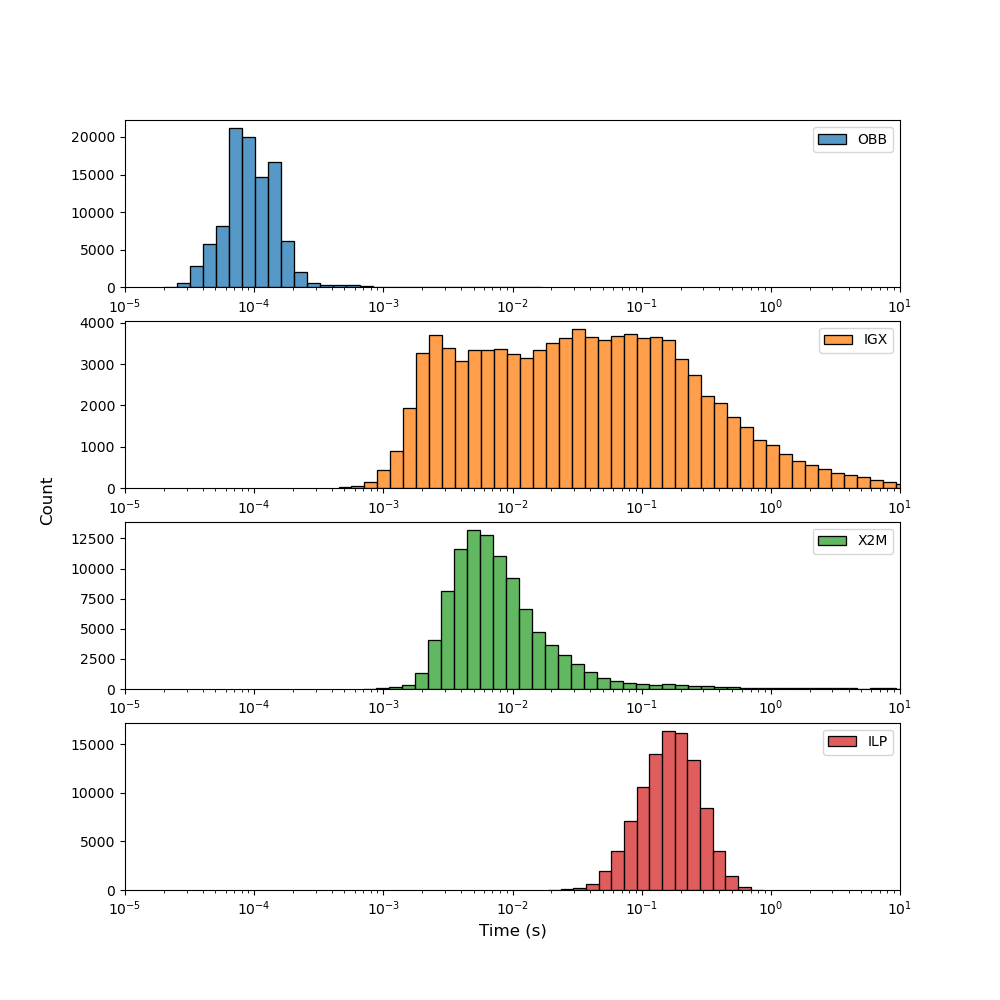

In [81]:
from IPython.display import Image, display
display(Image(TIMEFIG))

## Post-analysis

Items that BOSolver converted into molecular graphs showing less nOctet values.

In [ ]:
t = ana[(ana["nOctet_bos"] < ana["nOctet_x2m"]) | (ana["nOctet_bos"] < ana["nOctet_igx"]) | (ana["nOctet_bos"]< ana["nOctet_obb"])][["name"]+[col for col in ana.columns if "bos" in col]]
items = ana.loc[t.index, t.columns]
items

,name,chg_ilp,ChemVal_ilp,ChgConserve_ilp,NoRadical_ilp,Sanitize_ilp,ChemStab_ilp,BOSum_ilp,ChgSepa_ilp,nAromatic_ilp,nOctet_ilp
773,101747.xyz,0,3,1,1,1,28,30,2,0,31
2031,105397.xyz,0,3,1,1,1,16,24,8,0,17
2654,107336.xyz,0,3,1,1,1,76,66,2,12,53
3762,110767.xyz,0,3,1,1,1,24,36,12,0,27
4158,111919.xyz,0,3,1,1,1,26,38,12,0,20
...,...,...,...,...,...,...,...,...,...,...,...
95057,88543.xyz,0,3,1,1,1,29,25,2,6,21
95222,88971.xyz,0,3,1,1,1,20,22,2,0,23
95674,90043.xyz,0,3,1,1,1,22,32,10,0,24
96102,91129.xyz,0,3,1,1,1,60,62,2,0,57


Items that BOSolver did not converted in to the most *ChemStab* molecular graph (chemical structure)

In [ ]:
nostab = chemstab_res.loc[~chemstab_res.str.contains("BOS"), ["name"]]
unsuccessful = ana[ana.loc[ana["name"].isin(nostab), ["ChemVal_ilp"]] == 3]
#unsuccessful = nostab[nostab["ChemVal_ilp"]==3]
#unsuccessful[["name", "nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_ilp"]]

0                OBB
148          IGX,X2M
169          IGX,X2M
170          IGX,X2M
172          IGX,X2M
             ...    
100655    all failed
100656    all failed
100657    all failed
100658    all failed
100659    all failed
Length: 2286, dtype: object

In [23]:
#unsuccessful.loc[99567][["nOctet_ilp", "nOctet_igx"]]

label과 비교해서 이긴 것들 (진 것들들)

In [ ]:
vs_lab[vs_lab["bos"]==-1]

다 실패한 것들

In [ ]:
obb_check = (ana["ChemVal_obb"] != 3).fillna(True)
igx_check = (ana["ChemVal_igx"] != 3).fillna(True)
x2m_check = (ana["ChemVal_x2m"] != 3).fillna(True)
bos_check = (ana["ChemVal_bos"] != 3).fillna(True)
ana[obb_check & igx_check & x2m_check & bos_check]
#ana[ana["ChemVal_obb"] != 3 & ana["ChemVal_igx"] != 3 & ana["ChemVal_x2m"] != 3 & ana["ChemVal_bos"] != 3]

,name,chg_obb,ChemVal_obb,ChgConserve_obb,NoRadical_obb,Sanitize_obb,ChemStab_obb,BOSum_obb,ChgSepa_obb,nAromatic_obb,...,chg_lab,ChemVal_lab,ChgConserve_lab,NoRadical_lab,Sanitize_lab,ChemStab_lab,BOSum_lab,ChgSepa_lab,nAromatic_lab,nOctet_lab
385,100848.xyz,0,2,1,1,0,<NA>,<NA>,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
797,101827.xyz,0,2,1,1,0,<NA>,<NA>,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1262,103099.xyz,0,2,1,1,0,<NA>,<NA>,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1311,103273.xyz,0,2,1,1,0,<NA>,<NA>,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1371,103483.xyz,0,2,1,0,1,<NA>,<NA>,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100655,Valence of atom 9 is 4 which bigger than allow...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
100656,Valence of atom 9 is 5 which bigger than allow...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
100657,Valence of atom 9 is 5 which bigger than allow...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
100658,Valence of atom 9 is 5 which bigger than allow...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
#chemstab_res.iloc[np.flatnonzero(ana["name"]=="000215597.xyz")[0]]

In [ ]:
chg_col = [col for col in ana.columns if "chg" in col]
min_ChgSepa = ana[["ChgSepa_" + col for col in ["obb", "igx", "x2m", "bos", "lab"]]].min(axis=1)
max_nOctet = ana[["nOctet_" + col for col in ["obb", "igx", "x2m", "bos", "lab"]]].max(axis=1)
max_BOSum = ana[["BOSum_" + col for col in ["obb", "igx", "x2m", "bos", "lab"]]].max(axis=1)
max_nAromatic = ana[["nAromatic_" + col for col in ["obb", "igx", "x2m", "bos", "lab"]]].max(axis=1)


#print(ana.shape)
#print(min_ChgSepa)
#print(min_ChgSepa.iloc[51209])
#print(min_ChgSepa[min_ChgSepa==2])
#ana[ana["ChgSepa_bos"] != min_ChgSepa][["name"]+["chg_" + col for col in ["obb", "igx", "x2m", "bos"]]].tail(5)
no_ChgSepa = ana[ana["ChgSepa_bos"] != min_ChgSepa]
no_nOctet = ana[ana["nOctet_bos"] != max_nOctet]
no_BOSum = ana[ana["BOSum_bos"] != max_BOSum]
no_nAromatic = ana[ana["nAromatic_bos"] != max_nAromatic]
ana[ana["name"] == "000005726.xyz"][['name', 'nOctet_igx', 'nOctet_x2m', 'nOctet_bos', 'nOctet_lab']]

,name,nOctet_igx,nOctet_x2m,nOctet_ilp,nOctet_lab


### Examples and Visualization

In [ ]:
def show_good_and_bad(good, bad):
    Chem.RemoveStereochemistry(good); Chem.RemoveStereochemistry(bad)
    rdDepictor.Compute2DCoords(good); rdDepictor.Compute2DCoords(bad);
    rdDepictor.StraightenDepection(good); rdDepictor.StraightenDepection(bad);
    Draw.MolsToGridImage([good, bad], molsPerRow=2, subImgSize=(500,500), labels=["good (BOSolver)", "bad"])

Bad Openbabel Examples

In [ ]:
name=1
good, _ = main_charge(XYZ / f"{name}.xyz", 0)
bad, _ = obabel_charge(XYZ / f"{name}.xyz", 0)

show_good_and_bad(good, bad)

Bad xyz2mol Examples

Bad IndigoX Examples